In [1]:

from IPython.core.display import HTML
#this css file can be downloaded from [David's repo](https://github.com/ketch/PseudoSpectralPython/blob/master/custom.css)
#Then set the address of css file as per your address of file
#Following two commands are not needed for calculations.
css_file = '/Users/rajvanmp/Downloads/custom.css'

HTML(open(css_file, "r").read())

In [2]:
from scipy import integrate
import sympy as sp
import numpy as np
import sys
from numpy import linalg as la 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
matplotlib.rcParams['animation.embed_limit'] = 2**128


HTML(open(css_file, "r").read())
font = {'size'   : 15}
matplotlib.rc('font', **font)
#from RKSchemes import ImEx_schemes
from Homogenized_system_coefficients import C_values
from Homogenized_system_coefficients import Homogenized_system_coef
fft = np.fft.fft
ifft = np.fft.ifft

from IPython.display import HTML
css_file = '/Users/rajvanmp/Downloads/custom.css'

In [68]:




font = {'size'   : 15}
matplotlib.rc('font', **font)

fft = np.fft.fft
ifft = np.fft.ifft

def plot_solution(frames, x, tt, xi):
    fig = plt.figure(figsize=(12,8))
    axes = fig.add_subplot(211)
    axes2 = fig.add_subplot(212)
    line, = axes.plot(x,frames[0][:,0],lw=3)
    line2, = axes2.plot(x,frames[0][:,1],lw=3)
    
    #axes2.semilogy([xi_max/2.,xi_max/2.],[1.e-6,4e8],'--r')
    #axes2.semilogy([-xi_max/2.,-xi_max/2.],[1.e-8,4e10],'--r')
    axes.set_ylabel(r'$\rho$',fontsize=30)
    axes2.set_ylabel(r'$q$',fontsize=30)
    plt.tight_layout()
    plt.close()

    def plot_frame(i):
        line.set_data(x,frames[i][:,0])
        #power_spectrum = np.abs(uuhat[i])**2
        line2.set_data(x,frames[i][:,1])
        axes.set_title('t= %.2e' % tt[i])
        axes.set_xlim((-np.pi,np.pi))
        axes.set_ylim((0.95,2.0))
        axes2.set_xlim((-np.pi,np.pi))
        axes2.set_ylim((-1,1))

    anim = matplotlib.animation.FuncAnimation(fig, plot_frame,
                                              frames=len(frames), interval=100,
                                              repeat=False)
    return HTML(anim.to_jshtml())

In [69]:
a = lambda y: np.sin(2*np.pi*y)+5
dady= lambda y: 2*np.pi*np.cos(2*np.pi*y)
delta = 0.001
C1, C2, C3, C4, C5, C6, C7, C8, avga,ainvavg = C_values(a=a,dady=dady,delta=delta)

In [70]:
gamma = 1.4 
kappa =1
p_0 = 1
P1 = gamma*kappa*p_0**(gamma-1)
P11= (gamma-1)*gamma*kappa*p_0**(gamma-2)
r1,r2,r3,r4,r5,r6,k1,k2,k3,k4,k5,k6,k7=Homogenized_system_coef(C1,C2,C3,C4,C5,C6,C7,C8,avga,ainvavg,p_0,P1,P11,delta)

In [71]:
L = 2*np.pi; m = 512
x = np.arange(-m/2,m/2)*(L/m)
xi = np.fft.fftfreq(m)*m*2*np.pi/L
A = 0.5
rho0 = p_0 + A*np.exp(-2.36*(x)**2)
q0 = np.zeros_like(rho0)
#u0 = np.zeros(2*m)
rho_ini = rho0+1j*np.zeros_like(rho0)
q_ini  = q0 + 1j*np.zeros_like(q0)
#u0[:m] = rho0; u0[m:] = q0

rhoq_ini = np.array([[rho_ini[i],q_ini[i]] for i in range(q_ini.shape[0])])


omega = (1.0/avga)*(-1j*xi+r6*(1j*xi)**3)
bta = k1*1j*xi
chk = np.ones_like(xi)
l = [[[chk[i],-omega[i]],[-bta[i],chk[i]]] for i in range(len(xi))]
f = np.array([[rho0[i],q0[i]] for i in range(len(x))])
#dtl = -bta+omega
mt = np.array(l)
#lmdamat = [[-(bta/dtl), omega/dtl],[-(1.0/dtl), 1.0/dtl]]
lmdamat = np.linalg.inv(mt)
print(mt.shape, mt.dtype,lmdamat.shape,rhoq_ini.shape,rhoq_ini.dtype)

(512, 2, 2) complex128 (512, 2, 2) (512, 2) complex128


In [72]:
ft = np.zeros_like(f)+1j*np.zeros_like(f)
ft[:,0]=np.fft.fft(f[:,0])
ft[:,1]=np.fft.fft(f[:,1])
bbb = np.squeeze(np.matmul(lmdamat,np.expand_dims(ft,axis=-1)))
bbb.shape

(512, 2)

In [73]:
def rhs_linear(uft,u,xi):
    #Evaluate the linear term
    m = len(xi)
    #rho = u[:m]; q = u[m:];
    rho = u[:,0]
    q = u[:,1]
    v = np.zeros_like(u)
    rhohat = uft[:,0]
    qhat = uft[:,1]
    rhohat = np.real(ifft(1j*xi*rhohat))
    qhat = np.real(ifft(1j*xi*qhat))
    rhs_rho = (1/avga)*(-qhat + r6*np.real(ifft((1j*xi)**3 *fft(q))))
    rhs_q = k1*rhohat
    v[:,0] = rhs_rho; v[:,1] = rhs_q;
    return v

In [74]:
def rhs_nonlinear(u,uft, xi):
    #Evaluate the nonlinear term
    m = len(xi)
    rho = u[:,0]; q = u[:,1];
    v = np.zeros_like(u)
    rhox_f = np.real(ifft(1j*xi*fft(rho))); rh0xx_f = np.real(ifft((1j*xi)**2 *fft(rho)));
    qx_f = np.real(ifft(1j*xi*fft(q))); qxx_f = np.real(ifft((1j*xi)**2 *fft(q)));
    rhohat = fft(rho); qhat = fft(q)
    rhs_rho = (1/avga)*( r1*q*rhox_f + r2*q**2*qx_f + r3*q*rh0xx_f  + \
                       r4*rhox_f*qx_f + r5*rho*q*rhox_f ) + 1.e-16
    rhs_q = k2*q*qx_f + k3*rho*q*qx_f + (k4*q**2 + k5*rho)*rhox_f + k6*qx_f**2 + k7*q*qxx_f + 1.e-16
    v[:,0] = rhs_rho; v[:,1] = rhs_q;
    return v

In [75]:
sys.path.append('/Users/rajvanmp/station_X/pyGP_fields')

In [76]:
from GPE import GPE_scalar_field
from GPE import ImEx
from GPE import GPE_scalar_field_1d2c

In [77]:
A    = np.array([[0,0,0],[5/6.,0,0],[11/24,11/24,0]])
Ahat = np.array([[2./11,0,0],[205/462.,2./11,0],[2033/4620,21/110,2/11]])
b = np.array([24/55.,1./5,4./11])
bhat = b

imx = ImEx(3,Ahat,A,bhat,b)

In [78]:
def run_HE_example(dt):
    
    T = 100.0 
    tmax = T

    

    num_plots = 50
    nplt = np.floor((tmax/num_plots)/dt)
    nmax = int(round(tmax/dt))
    #print(nplt,"nmax",nmax)

    frames = [rhoq_ini.real]
   
    tt = [0]
    err_l = []
    mass_l = []
    mass_err_l=[]
    
    rhoq = GPE_scalar_field_1d2c(m,2,rhs_linear,rhs_nonlinear,imx,rhoq_ini)
    
    
    for n in range(0,nmax):
        
        #print(n)
        for k in range(imx.s):
            rhoq.update_stage_sum(k,dt)
            
            rhoq.do_fft(k,lmdamat,dt)
            
            rhoq.update_K(k,xi)
           
            
            
            
        rhoq.sum_contributions(dt)
        
        
        
        t = (n+1)*dt
        

        
        
        if np.mod(n,nplt) == 0:
            frames.append(rhoq.psi.real)
            
            tt.append(t)
            
            #err = sol_err(psi.psi,t,nx,T,max_err)
           # err_l.append(err)
            
           # mass = psi_1.calc_mass()+psi_2.calc_mass()
           # mass_err = (mass-mass_ini)/mass_ini
            
          ##  mass_l.append(mass)
           # mass_err_l.append(mass_err)
            
            print("time ",t/tmax)
            


    #err =  sol_err(psi.psi,t,nx,T,max_err)
    #err_l.append(err)
            
   # mass = psi_1.calc_mass()+psi_2.calc_mass()
    #mass_err = (mass-mass_ini)/mass_ini
            
   # mass_l.append(mass)
   # mass_err_l.append(mass_err)
       
    return frames,tt
    

In [79]:
f1,tt = run_HE_example(0.01)

class shapes (512, 2) (3, 512, 2)
my shape (512, 2) psi shape (512, 2)
time  0.0001
time  0.020100000000000003
time  0.0401
time  0.0601
time  0.0801
time  0.1001
time  0.1201
time  0.1401
time  0.16010000000000002
time  0.1801
time  0.20010000000000003
time  0.22010000000000002
time  0.2401
time  0.2601
time  0.2801
time  0.30010000000000003
time  0.3201
time  0.34009999999999996
time  0.3601
time  0.3801
time  0.40009999999999996
time  0.4201
time  0.4401
time  0.46009999999999995
time  0.48009999999999997
time  0.5001
time  0.5201
time  0.5401
time  0.5600999999999999
time  0.5801
time  0.6001
time  0.6201
time  0.6401
time  0.6601
time  0.6801
time  0.7001000000000001
time  0.7201000000000001
time  0.7401000000000001
time  0.7601
time  0.7801
time  0.8001
time  0.8201
time  0.8401000000000001
time  0.8601000000000001
time  0.8801000000000001
time  0.9001
time  0.9201
time  0.9401
time  0.9601000000000001
time  0.9801000000000001


In [80]:
plot_solution(f1,  x, tt, xi)

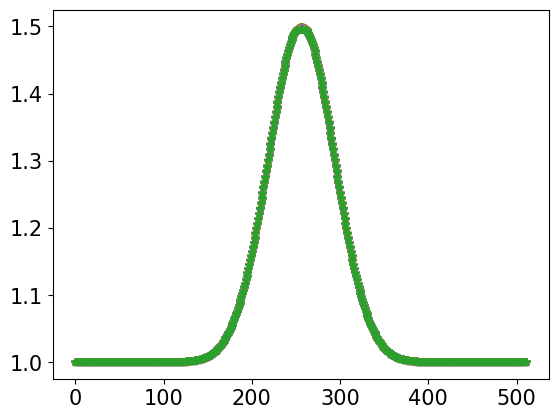

In [16]:
mrk = ("b--","r-.","-*","m--")
for i in range(len(f1)):
    ax = plt.subplot()
    j=i%4
    ax.plot(f1[i][:,0],mrk[j],label=str(i))

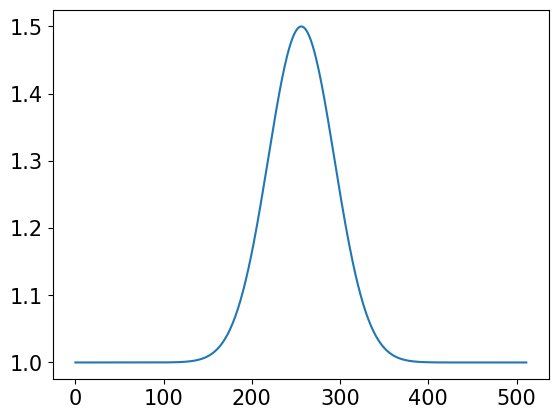

In [18]:
plt.plot(f1[0][:,0])